# 2022-11-28 Finite Volume

## Last time

* CEED Fluids for compressible viscous flow
* Solvers
* Boundary conditions

## Today

* Notes on unstructured meshing workflow
* Finite volume methods for hyperbolic conservation laws
* Riemann solvers for scalar equations
  * Shocks and the Rankine-Hugoniot condition
  * Rarefactions and entropy solutions

In [1]:
using LinearAlgebra
using Plots
default(linewidth=3)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664


ode_rk_explicit (generic function with 1 method)

# Unstructured meshing

* CAD models: spline-based (NURBS) geometry
  * Label materials, boundary surfaces
  * Proprietary formats or lossy open formats
* Geometry clean-up
  * Remove rivets, welds, brazing, bolt/thread detail
* Mesh generation
  * Tetrahedral meshing mostly automatic
  * Hexahedral meshes often more efficient (e.g., locking in elasticity)
    * Manually decompose geometry
    * Various algorithms with poor quality elements
  * Usually single node with lots of memory
  

* Simulation
  * Read, partition, solve, write output
* Load in visualization software (e.g., Paraview, VisIt)
  * Visualization outputs usually contain derived quantities
    * Stress, velocity, pressure, temperature, vorticity
  * Frequent checkpoints are commonly a bottleneck

# Finite Volume methods for hyperbolic conservation laws

Hyperbolic conservation laws have the form

$$ \frac{\partial \mathbf q}{\partial t} + \nabla\cdot F(\mathbf q) = 0 $$

where the (possibly nonlinear) function $F(\mathbf q)$ is called the **flux**.  If $\mathbf q$ has $m$ components, $F(\mathbf q)$ is an $m\times d$ matrix in $d$ dimensions. 

We can express finite volume methods by choosing test functions $\mathbf v(x)$ that are piecewise constant on each element $e$ and integrating by parts
\begin{split} \int_\Omega \mathbf v \frac{\partial \mathbf q}{\partial t} + \mathbf v \nabla\cdot F(\mathbf q) = 0 \text{ for all } \mathbf v \\
 \frac{\partial}{\partial t} \left( \int_e \mathbf q \right) + \int_{\partial e} F(\mathbf q) \cdot \hat n = 0 \text{ for all } e .
\end{split}

In finite volume methods, we choose as our unknowns the average values $\bar{\mathbf q}$ on each element, leading to the discrete equation
$$ \lvert e \rvert \frac{\partial \bar{\mathbf q}}{\partial t} + \int_{\partial e} F(\mathbf q) \cdot \hat n = 0 \text{ for all } e $$
where $\lvert e \rvert$ is the volume of element $e$.

The most basic methods will compute the interface flux in the second term using the cell average $\bar{\mathbf q}$, though higher order methods will perform a reconstruction using neighbors.
Since $\bar{\mathbf q}$ is discontinuous at element interfaces, we will need to define a numerical flux using the (possibly reconstructed) value on each side.

# Examples of hyperbolic conservation laws in 1D

## Advection
$$ \frac{\partial u}{\partial t} + \nabla\cdot (\underbrace{c u}_{F(u)}) = 0 $$
where $c$ is velocity.  In the absence of boundary conditions, this has the solution
$$ u(t,x) = u(0, x-ct) $$
in terms of the initial condition.  Lines of constant $x-ct$ are called **characteristics**.
* The wave speed is $F'(u) = c$, a constant.

## Burger's Equation
$$ \frac{\partial u}{\partial t} + \nabla\cdot \underbrace{\left(\frac{u^2}{2}\right)}_{F(u)} = 0 $$
is a model for nonlinear convection.
* The wave speed is $F'(u) = u$.

## Traffic

$$ \frac{\partial u}{\partial t} + \nabla\cdot \big(\underbrace{u (1-u)}_{F(u)} \big) = 0 $$
where $u \in [0,1]$ represents density of cars and $1-u$ is their speed.
* The wave speed is $F'(u) = 1 - 2u$, representing the speed at which kinematic waves travel.
* This is a non-convex flux function.

# First crack at a numerical flux

We represent the solution in terms of cell averages $\bar u$, but need to compute
$$ \int_{\partial e} F(u) \cdot \hat n $$
on the boundary of each cell (i.e., on each face).  For interior faces, the flux $F(u)$ must be the same when viewed from either side.  As a first idea for an accurate numerical method, we could average the values from the left and right side of each face,
$$ u_{\text{face}} = \frac{\bar u_L + \bar u_R}{2} .$$
Let's try that.

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1664


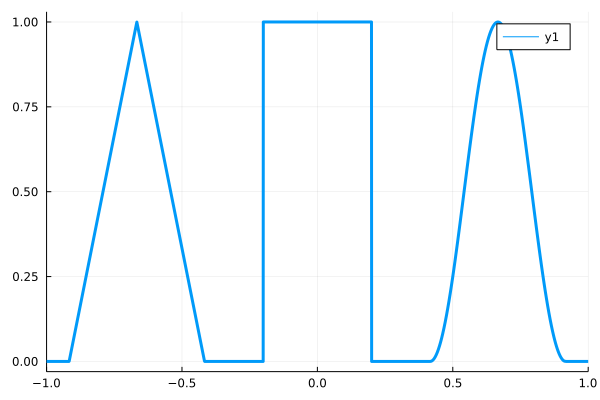

In [2]:
function testfunc(x)
    max(1 - 4*abs.(x+2/3),
        abs.(x) .< .2,
        (2*abs.(x-2/3) .< .5) * cospi(2*(x-2/3)).^2
    )
end
plot(testfunc, xlims=(-1, 1))

# An implementation

In [3]:
flux_advection(u) = u
flux_burgers(u) = u^2/2
flux_traffic(u) = u * (1 - u)

function fv_solve0(flux, u_init, n, tfinal=1)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        uL = .5 * (u + u[idxL])
        uR = .5 * (u + u[idxR])
        (flux.(uL) - flux.(uR)) / h
    end
    thist, uhist = ode_rk_explicit(rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

fv_solve0 (generic function with 2 methods)

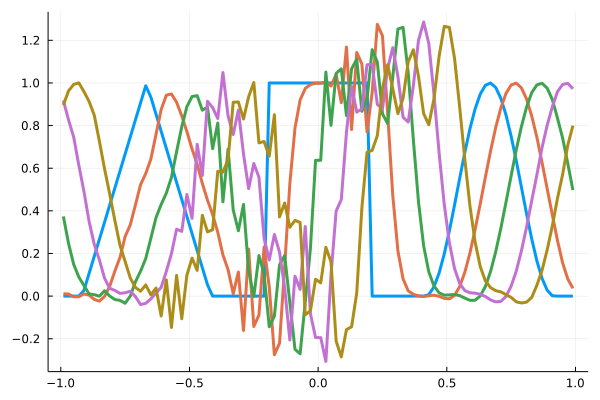

In [11]:
x, thist, uhist = fv_solve0(flux_advection, testfunc, 100, .4)
plot(x, uhist[:,1:5:end], legend=:none)

Evidenitly our method has serious problems for discontinuous solutions and nonlinear problems.

# Shocks, rarefactions, and Riemann problems

Burger's equation evolved a discontinuity in finite time from a smooth initial condition.  It turns out that all nonlinear hyperbolic equations have this property.  For Burgers, the peak travels to the right, overtaking the troughs.
* This is called a **shock** and corresponds to characteristics converging when the gradient of the solution is negative.
* When the gradient is positive, the characteristics diverge to produce a **rarefaction**.  The relationship to positive and negative gradients is reversed for a non-convex flux like Traffic.

We need a solution method that can correctly compute fluxes in case of a discontinuous solution.  Finite volume methods represent this in terms of a Riemann problem,
$$ u(0, x) = \begin{cases}
u_L & \text{if} & x < 0 \\
u_R & \text{if} & x > 0
\end{cases}
$$
where $u_L$ and $u_R$ are given.  The solution of a Riemann problem is the solution $u(t, x)$ at positive times.  In our finite volume schemes, it will be sufficient to compute the flux at $x=0$ at an infinitessimal positive time
$$\tilde F(u_L, u_R) = \lim_{t\to 0} F\big(u(t, 0) \big) . $$
We call $\tilde F$ the **numerical flux** and require that it must be consistent when there is no discontinuity,
$$ \tilde F(u, u) = F(u) .$$

# A solver based on Riemann problems

In [12]:
riemann_advection(uL, uR) = 1*uL # velocity is +1

function fv_solve1(riemann, u_init, n, tfinal=1)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        fluxL = riemann(u[idxL], u)
        fluxR = riemann(u, u[idxR])
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

fv_solve1 (generic function with 2 methods)

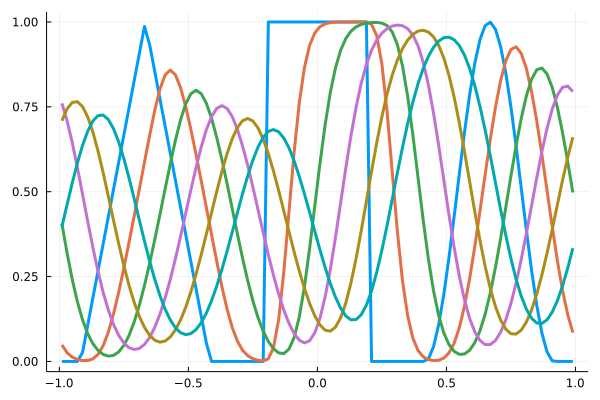

In [13]:
x, thist, uhist = fv_solve1(riemann_advection, testfunc, 100, .5)
plot(x, uhist[:,1:5:end], legend=:none)

## Observations
* Good: no oscillations/noisy artifacts: solutians are bounded between 0 and 1, just like exact solution.
* Bad: Lots of numerical diffusion.

# Rankine-Hugoniot condition

For a nonlinear equation, we need to know which direction the shock is moving.  If we move into the reference frame of the shock, the flux on the left must be equal to the flux on the right.  This leads to shock speed $s$ satisfying
$$ s (\underbrace{u_R - u_L}_{\Delta u}) = (\underbrace{F(u_R) - F(u_L)}_{\Delta F}) \cdot \hat n $$
where $\hat n$ is any direction (e.g., the normal to a face in a multi-dimensional finite volume method).
This condition holds also for hyperbolic system.

For Burger's equation
$$ \frac{\partial u}{\partial t} + \nabla\cdot (u^2/2) = 0, $$
our Riemann problem produces a shock if $u_L > u_R$, i.e., $\Delta u < 0$.
The shock moves to the right $(s > 0)$ if $\Delta F < 0$, i.e., $F(u_L) > F(u_R)$.

![Toro (2009) Figure 2.13](../img/Toro-Shock-2.13.png)

So if the solution is a shock, the numerical flux is the maximum of $f(u_L)$ and $f(u_R)$.
We still don't know what to do in case of a rarefaction so will just average and see what happens.

# Burgers Riemann problem (shock)

In [14]:
function riemann_burgers_shock(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        flux[i] = if uL[i] > uR[i] # shock
            max(flux_burgers(uL[i]), flux_burgers(uR[i]))
        else
            flux_burgers(.5*(uL[i] + uR[i]))
        end
    end
    flux
end

riemann_burgers_shock (generic function with 1 method)

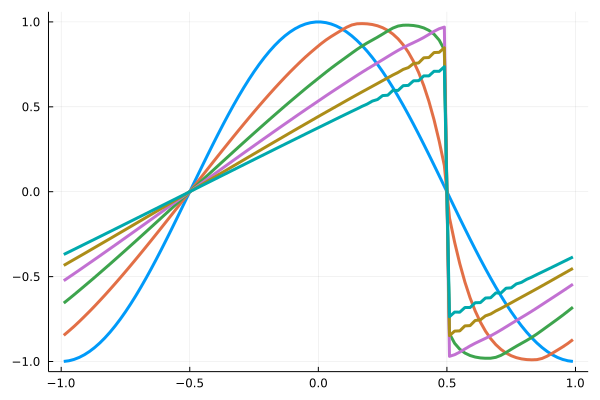

In [15]:
x, thist, uhist = fv_solve1(
    riemann_burgers_shock, cospi, 100, 1)
plot(x, uhist[:,1:10:end], legend=:none)

# Rarefactions

This solution was better, but we still have odd ripples in the rarefaction. This is an **expansion shock**, which is a **mathematical solution** to the PDE, but not a physical solution.

![Toro (2009) Figure 2.14](../img/Toro-ShockRarefaction-2.14.png)

but this violates the **entropy condition**
$$ F'(u_L) > s > F'(u_R) . $$
Shocks are compressive phenomena and physical solutions to the expansive scenario $F'(u_L) < F'(u_R)$ are rarefactions.

# Physical rarefactions

![Toro (2009) Figure 2.16](../img/Toro-Rarefaction-2.16.png)

We need to color into the rarefaction in a physical way. We can justify this by considering the hyperbolic problem to be the singular limit of a problem with diffusion/viscosity, leading to "viscosity solutions".

# Entropy functions



Consider a smooth function $\eta(u)$ that is convex $\eta''(u) > 0$ and a smooth solution $u(t,x)$.
Then
$$ u_t + F(u)_x = 0 $$
is equivalent to
$$ u_t + F'(u) u_x = 0 $$
and we can write
$$ \eta'(u) u_t + \eta'(u) F'(u) u_x = 0 . $$
If we find a function $\psi(u)$ such that $\psi'(u) = \eta'(u) F'(u)$, the equation above is equivalent (for smooth solutions) to
$$ \eta(u)_t + \psi(u)_x = 0 $$
which is a conservation law for the entropy $\eta(u)$ with entropy flux $\psi(u)$.


Now consider the parabolic equation
$$ u_t + F(u)_x -\epsilon u_{xx} = 0 $$
for some positive $\epsilon$.

This equation has a smooth solution for any $\epsilon > 0$ and $t > 0$ so we can multiply by $\eta'(u)$ as above and apply the chain rule to yield
$$ \eta(u)_t + \psi(u)_x - \epsilon \eta'(u) u_{xx} = 0 . $$
Rearranging the last term produces
$$ \eta(u)_t + \psi(u)_x - \epsilon \Big( \eta'(u) u_x \Big)_x = - \epsilon \eta''(u) u_x^2 . $$
If both terms involving $\epsilon$ were to vanish, we would be left with conservation of entropy.

# Entropy solutions: $\epsilon\to 0$

$$ \eta(u)_t + \psi(u)_x - \epsilon \Big( \eta'(u) u_x \Big)_x = - \epsilon \eta''(u) u_x^2 $$

## Left side
$$ \int_a^b \Big( \eta'(u) u_x \Big)_x dx = \eta'(u) u_x |_{x=a}^b $$
which is bounded independent of the values $u_x$ may take inside the interval.  Consequently, the left hand side reduces to a conservation law in the limit $\epsilon\to 0$.

## Right side

The integral of the right hand side, however, does not vanish in the limit since
$$\int_a^b u_x^2$$ is unbounded as $u_x$ grows.
* $\eta(u)$ being convex implies $\eta''(u) > 0$.

So entropy must be dissipated across shocks,
$$ \eta(u)_t + \psi(u)_x \le 0, $$
with equality for smooth solutions and strict inequality at shocks.

# Mathematical versus physical entropy

Our choice of $\eta(u)$ being a convex function $\eta''(u) > 0$ causes entropy to be **dissipated** across shocks.  This is the convention in math literature because convex analysis chose the sign (versus "concave analysis").

Physical entropy is **produced** by such processes, so $-\eta(u)$ would make sense as a physical entropy.

## Uniqueness

While any convex function will work to show uniqueness for **scalar** conservation laws, that is not true of hyperbolic **systems**, for which the "entropy pair" $(\eta, \psi)$ should satisfy a symmetry property. A "physical entropy" exists for real systems, and may be used for this purpose.

## Shallow water

$$\begin{bmatrix} h \\ h\mathbf u \end{bmatrix}_t + \nabla\cdot\begin{bmatrix} h\mathbf u \\ h \mathbf u \otimes \mathbf u + \frac{g}{2} h^2 \mathbf I \end{bmatrix} = 0$$

* conserve mass and momentum
* energy is only conserved for smooth solutions
* shocks (crashing waves) produce heat, but energy is not a state variable.
* Energy is the "entropy" of shallow water
$$ \eta = \underbrace{\frac h 2 \lvert \mathbf u \rvert^2}_{\text{kinetic}} + \underbrace{\frac g 2 h^2}_{\text{potential}}$$

# Looking into the rarefaction fan



In [16]:
function riemann_burgers(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_burgers(uL[i])
        fR = flux_burgers(uR[i])
        flux[i] = if uL[i] > uR[i] # shock
            max(fL, fR)
        elseif uL[i] > 0 # rarefaction all to the right
            fL
        elseif uR[i] < 0 # rarefaction all to the left
            fR
        else
            0
        end
    end
    flux
end

riemann_burgers (generic function with 1 method)

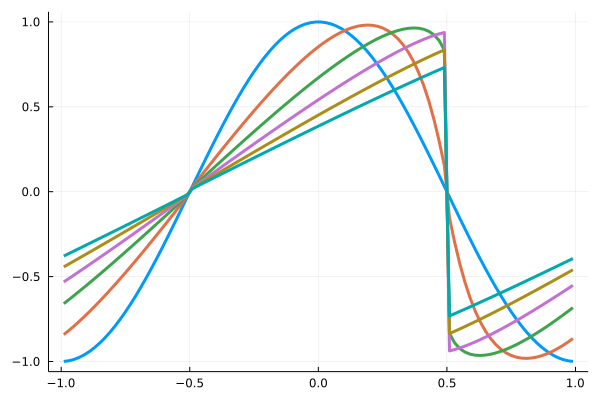

In [17]:
x, thist, uhist = fv_solve1(
    riemann_burgers, cospi, 100, 1)
plot(x, uhist[:,1:10:end], legend=:none)

# Traffic equation

Our flux function is
$$ f(u) = u (1 - u) $$
and corresponding wave speed is
$$ f'(u) = 1 - 2 u . $$
* **Shock**
The entropy condition for a shock
$$ f'(u_L) > f'(u_R) $$
occurs whenever $u_L < u_R$.
By Rankine-Hugoniot
$$ s \Delta u = \Delta f, $$
the shock moves to the right when $\Delta f = f(u_R) - f(u_L)$ is positive, in which case the flux is $f(u_L)$.  Taking the other case, the numerical flux for a shock is $\min[f(u_L), f(u_R)]$.

* **Rarefaction**
A rarefaction occurs when $u_L > u_R$ and moves to the right when $f'(u_L) > 0$ which is the case when $u_L < 1/2$.
Note that while $f'(1/2) = 0$ appears within a sonic rarefaction, the flux $f(1/2) \ne 0$.

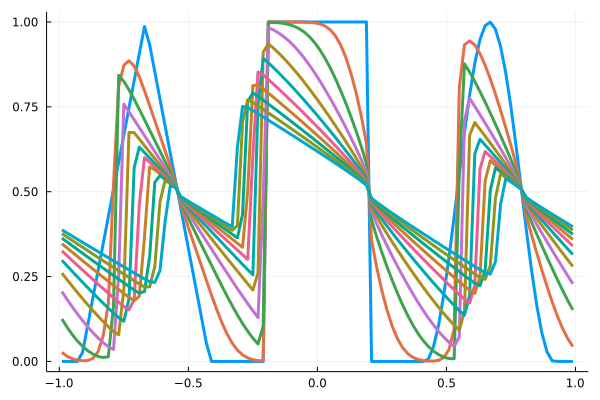

In [18]:
function riemann_traffic(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_traffic(uL[i])
        fR = flux_traffic(uR[i])
        flux[i] = if uL[i] < uR[i] # shock
            min(fL, fR)
        elseif uL[i] < .5 # rarefaction all to the right
            fL
        elseif uR[i] > .5 # rarefaction all to the left
            fR
        else
            flux_traffic(.5)
        end
    end
    flux
end
x, thist, uhist = fv_solve1(riemann_traffic, testfunc, 100, 1)
plot(x, uhist[:,1:5:end], legend=:none)

# Preview: Riemann problem for the Euler equations

<img src="../img/Toro-Euler-4.1.png" />

* Two nonlinear (acoustic) waves
  * Either is a shock or rarefaction
* One linearly degenerate (contact) wave
  * Not a shock or rarefaction
  * Pressure is constant across the contact wave
  * Different temperature and density
* Need to determine the wave structure to sample the flux.

# Further resources

## Book: Riemann Problems and Jupyter Solutions

[Riemann Problems and Jupyter Solutions: Theory and Approximate Solvers for Hyperbolic PDEs](http://www.clawpack.org/riemann_book/) by David I. Ketcheson, Randall J. LeVeque, and Mauricio del Razo Sarmina is an excellent compilation of Jupyter notebooks for learning about hyperbolic conservation laws and Riemann solvers.

You can [run in Binder](https://mybinder.org/v2/gh/clawpack/riemann_book/master) to interact with the notebooks without needing to install Clawpack.

## Riemann solvers and gas dynamics

[Toro: Riemann Solvers and Numerical Methods for Fluid Dynamics](https://link.springer.com/book/10.1007%2Fb79761#toc) (free download for CU students)